<a href="https://colab.research.google.com/github/HarlinLee/cogsci-missed-connections/blob/main/content_context_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle
import networkx as nx

In [2]:
from google.colab import drive
drive.mount('/content/drive') 
DRIVE_PATH = "/content/drive/My Drive/REU evolution of scientific fields"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Topic Modeling and Graph Community Results

In [3]:
with open(os.path.join(DRIVE_PATH, 'topics_df.pkl'), 'rb') as f:
  topics_df = pickle.load(f)

topic_id_to_keyword = dict(zip(topics_df['SupertopicId'], topics_df['SupertopicKeywords'].apply(lambda x: x[0])))
topic_id_to_keyword2 = dict(zip(topics_df['SupertopicId'], topics_df['SupertopicKeywords'].apply(lambda x: ','.join(x[:2]))))
topic_id_to_keyword3 = dict(zip(topics_df['SupertopicId'], topics_df['SupertopicKeywords'].apply(lambda x: ','.join(x[:3]))))

In [4]:
tmp = np.load(DRIVE_PATH+'/comm_detection.npz', allow_pickle=True)
community_dict_sorted = tmp['community_dict_sorted'].item()
comm_id_sort = tmp['comm_id_sort'].item()
comm_id_sort_reverse = tmp['comm_id_sort_reverse'].item()
c = tmp['c'].item()

# Topic Distribution

In [5]:
df = pd.DataFrame.from_dict(c, orient='index').rename(columns={0:'Community'})
df['Community'] = df['Community'].map(comm_id_sort_reverse)
df = topics_df.join(df, how = 'inner')
df = pd.crosstab(index=df['Community'], columns=df['SupertopicId'])
#df

In [6]:
colors_list = ['#C6CAFB','#646EF7','#70F8C9','#58D4F4','#EF95FB','#FACB51','#EE553B',
               '#F4A058','#F4A799','#AB62F8','#B6E880','#FADBC0','#E0C6FC','#5CCD97','#EE6390']

def plot_comm_pie_chart(comm_id):
  # Pie chart, where the slices will be ordered and plotted counter-clockwise:
  nonzero_bools = (df.iloc[comm_id,:] !=0)
  subset = df.iloc[comm_id,:][nonzero_bools]
  sizes = subset.sort_values(ascending=False)
  labels = sizes.index
  word_labels = [topic_id_to_keyword3[i] for i in labels]
  colors = [colors_list[i] for i in labels]

  def absolute_value(val):
    a  = int(val*sizes.sum()/100)
    if a > sizes.sum()/100*4:
      return a
    else:
      return ""

  fig1, ax1 = plt.subplots(figsize=(12,6))
  pie1 = ax1.pie(sizes, autopct = absolute_value,textprops={'fontsize':20},
        shadow=False, startangle=90, counterclock=False, labels=['']*len(sizes),
        colors = colors)
  
  plt.legend(pie1[0],word_labels, bbox_to_anchor=(1, 0, 0.5, 1), fontsize=16)
  
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title('Community ' + str(comm_id), fontsize= 24)
  plt.tight_layout()
  plt.savefig(DRIVE_PATH+'/'+'Community'+ str(comm_id)+'.pdf',bbox_inches='tight')
  plt.savefig(DRIVE_PATH+'/'+'CommunityLegend.png',bbox_inches='tight')
  plt.show()

In [7]:
df_norm = df.apply(lambda x: x/np.linalg.norm(x), axis=1) #l2 normalized
dot_topics = df_norm.dot(df_norm.T)
#dot_topics

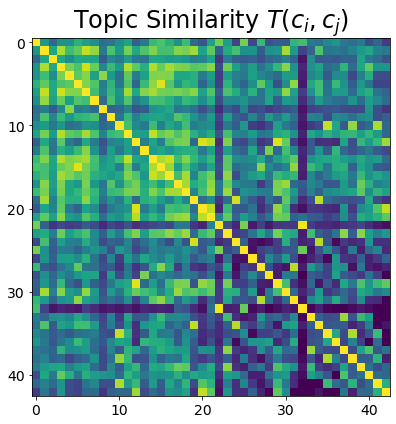

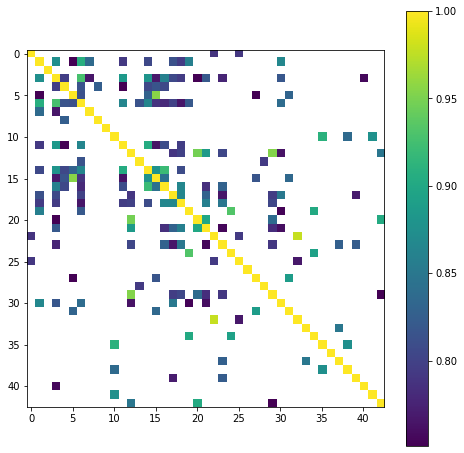

In [8]:
plt.figure(figsize=(8,6))
plt.imshow(dot_topics)
plt.tick_params(labelsize=14)
plt.yticks(range(0,len(dot_topics), 10))
plt.title('Topic Similarity $T(c_i, c_j)$', fontsize=24)
plt.tight_layout()
plt.savefig(DRIVE_PATH+'/'+'topic_similarity.pdf',bbox_inches='tight')
plt.show() 

plt.figure(figsize=(8,8))
plt.imshow(dot_topics[dot_topics > 0.75])
plt.colorbar() 
plt.show()

# Journal Distribution

In [9]:
with open(os.path.join(DRIVE_PATH, 'filtered_new_fields_df.pkl'), 'rb') as file:
    fields_df = pickle.load(file)
print(fields_df.shape)

id_to_published_in = dict(zip(fields_df['Id'], 
                              fields_df['J'].apply(lambda x: x['JN'] if isinstance(x, dict) else [])))

del fields_df

(59384, 18)


In [10]:
#Returns list of journals in a community
def list_community_journals(comm_id):
  comm_journals = [id_to_published_in[i] for i in community_dict_sorted[comm_id]]
  comm_journals = [i for i in comm_journals if not isinstance(i,list)]
  return comm_journals

In [11]:
def journal_inner(i,j): #Computes inner product of journal distributions
  journals_counts1 = pd.Series(list_community_journals(i)).value_counts()
  journals_counts2 = pd.Series(list_community_journals(j)).value_counts()
  norm1 = np.linalg.norm(journals_counts1)
  norm2 = np.linalg.norm(journals_counts2)
  journals1 = journals_counts1.apply(lambda x: x/norm1) #l2 normalized
  journals2 = journals_counts2.apply(lambda x: x/norm2)
  return pd.Series.mul(journals1,journals2, fill_value=0).sum() #mul aligns then multiplies (0 if one doesn't have)

dot_journal = np.zeros((len(community_dict_sorted),len(community_dict_sorted)))
for i in range(len(community_dict_sorted)): #Not optimized, takes ~10 sec
  for j in range(len(community_dict_sorted)): 
    dot_journal[i,j] = journal_inner(i, j)
dot_journal = pd.DataFrame(dot_journal)

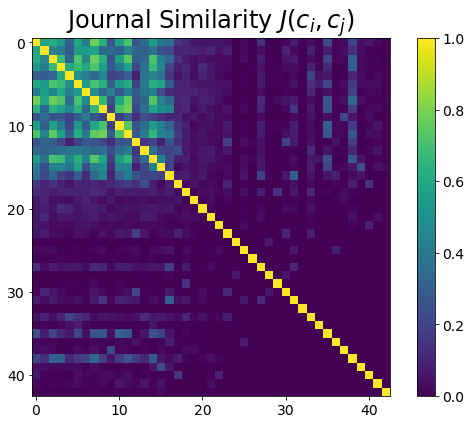

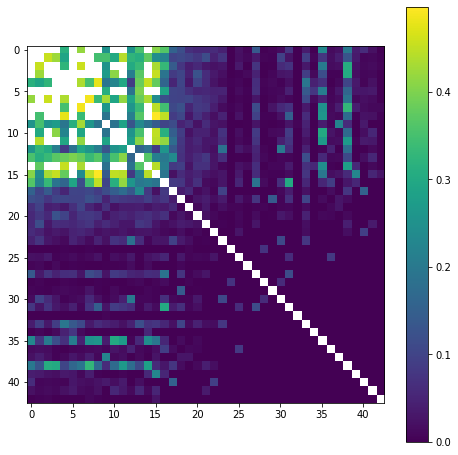

In [12]:
plt.figure(figsize=(8,6))
plt.imshow(dot_journal)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.tick_params(labelsize=14)
plt.yticks(range(0,len(dot_topics), 10))
plt.title('Journal Similarity $J(c_i, c_j)$', fontsize=24)
plt.tight_layout()
plt.savefig(DRIVE_PATH+'/'+'journal_similarity.pdf',bbox_inches='tight')
plt.show() 

plt.figure(figsize=(8,8))
plt.imshow(dot_journal[dot_journal < 0.5])
plt.colorbar() 
plt.show()

# Identify Regions of Interest, i.e. content-context discrepancy

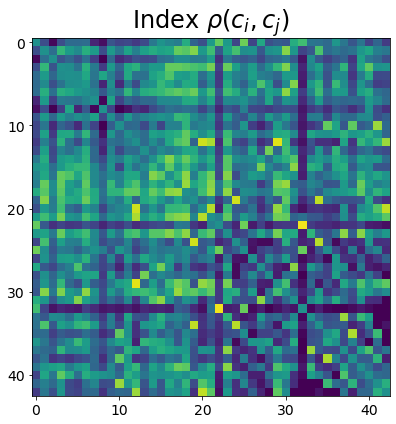

In [13]:
diff_index = dot_topics-0.5*dot_journal

plt.figure(figsize=(8,6))
plt.imshow(diff_index, vmin=0, vmax=1)
plt.tick_params(labelsize=14)
plt.yticks(range(0,len(dot_topics), 10))
plt.title(r'Index $\rho(c_i, c_j)$', fontsize=24)
plt.tight_layout()
plt.savefig(DRIVE_PATH+'/'+'diff_index.pdf',bbox_inches='tight')
plt.show() 


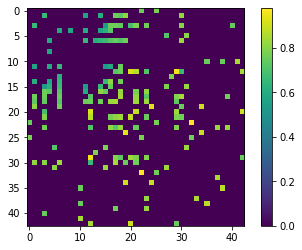

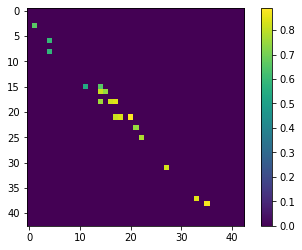

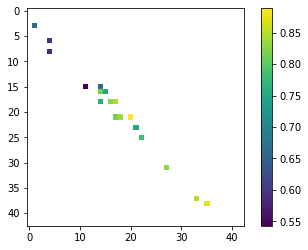

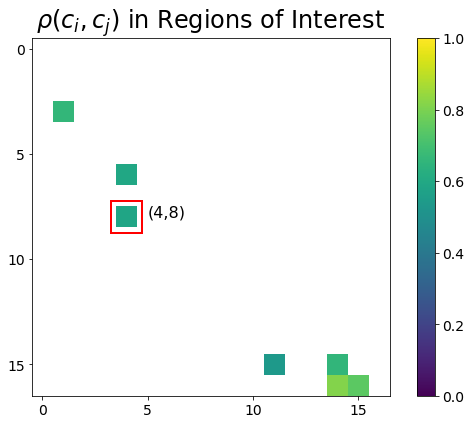

In [14]:
mask = np.multiply(dot_topics > 0.75, dot_journal < 0.5)
diff_index_mask = np.multiply(mask, diff_index)
plt.imshow(diff_index_mask)
plt.colorbar()
plt.show()

mask = np.multiply(mask, np.tril(np.ones(dot_topics.shape),-1) - np.tril(np.ones(dot_topics.shape), -5))
diff_index_mask = np.multiply(mask, diff_index_mask)
plt.imshow(diff_index_mask)
plt.colorbar()
plt.show()

diff_index_mask = diff_index_mask[diff_index_mask > 0.5]
plt.imshow(diff_index_mask)
plt.colorbar()
plt.show()

diff_index_mask = diff_index_mask.iloc[:17, :17]

plt.figure(figsize=(8,6))
plt.imshow(diff_index_mask, vmin=0, vmax=1)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.tick_params(labelsize=14)
plt.yticks(range(0,len(diff_index_mask)+1, 5))
plt.xticks(range(0,len(diff_index_mask)+1, 5))
plt.gca().add_patch(Rectangle((3.25,7.25),1.5,1.5,linewidth=2,edgecolor='r',facecolor='none'))
plt.text(5,8, '(4,8)', fontsize=16)
plt.title(r'$\rho(c_i, c_j)$ in Regions of Interest', fontsize=24)
plt.tight_layout()
plt.savefig(DRIVE_PATH+'/'+'diff_index_oi.pdf',bbox_inches='tight')
plt.show() 

7 pairs of interest
====
0 th pair: communities [16 14]
rho: 0.8146 T: 0.9204 J: 0.2116


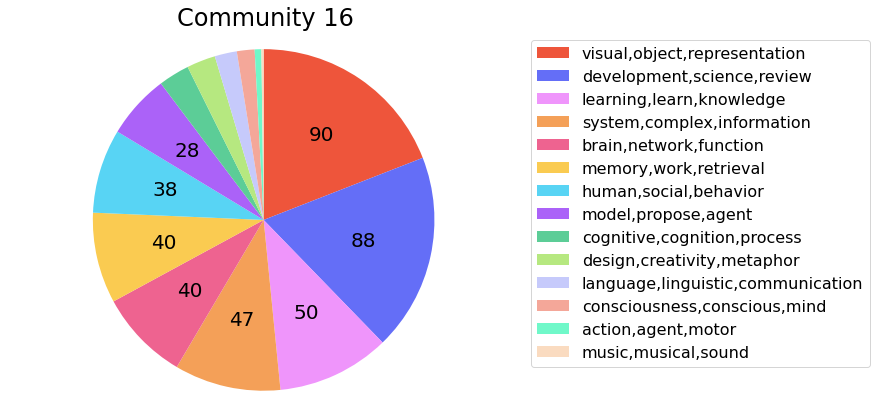

current biology                                                                               19
nature                                                                                         9
frontiers in psychology                                                                        9
journal of comparative physiology a neuroethology sensory neural and behavioral physiology     8
current opinion in insect science                                                              7
biorxiv                                                                                        7
current opinion in neurobiology                                                                7
the journal of experimental biology                                                            7
philosophical transactions of the royal society b                                              6
frontiers in behavioral neuroscience                                                           6
dtype: int64



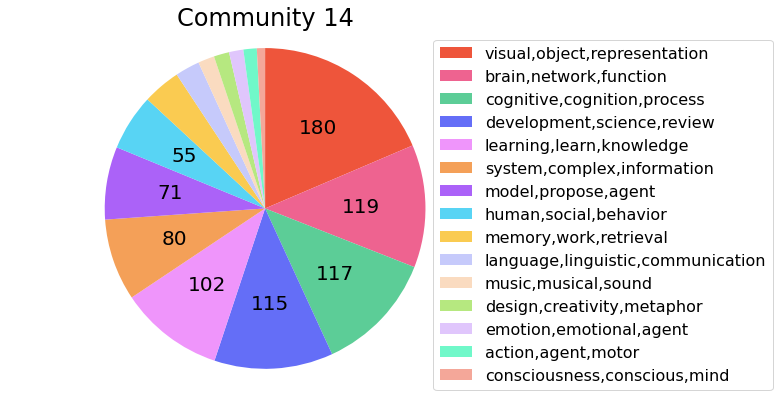

behavioral and brain sciences               40
trends in cognitive sciences                37
cognition                                   37
mind brain and education                    28
topics in cognitive science                 14
educational psychology review               13
intelligence                                13
journal of experimental child psychology    13
advances in psychology                      11
frontiers in human neuroscience             10
dtype: int64

=====
1 th pair: communities [16 15]
rho: 0.7486 T: 0.8445 J: 0.1919


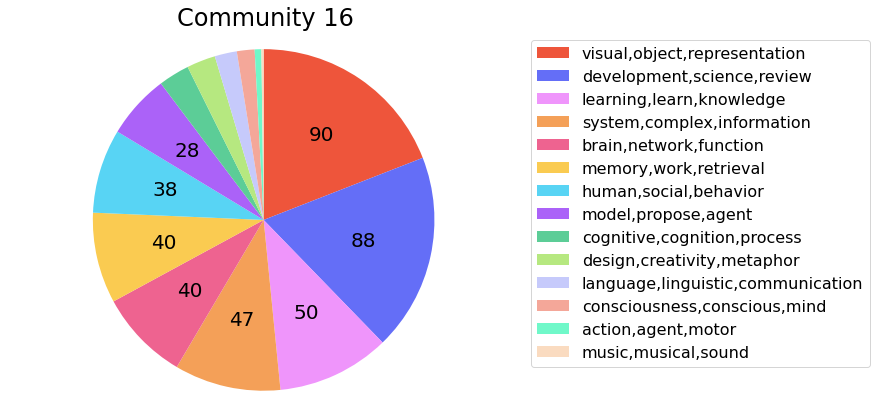

current biology                                                                               19
nature                                                                                         9
frontiers in psychology                                                                        9
journal of comparative physiology a neuroethology sensory neural and behavioral physiology     8
current opinion in insect science                                                              7
biorxiv                                                                                        7
current opinion in neurobiology                                                                7
the journal of experimental biology                                                            7
philosophical transactions of the royal society b                                              6
frontiers in behavioral neuroscience                                                           6
dtype: int64



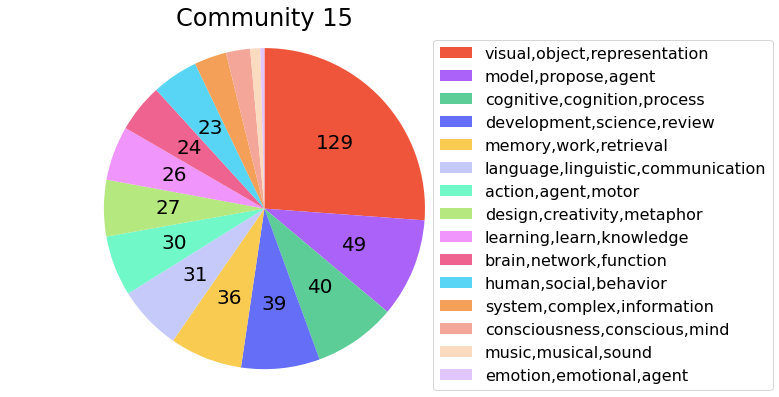

trends in cognitive sciences                                           15
journal of pragmatics                                                  14
journal of experimental psychology learning memory and cognition       10
cognitive neuropsychology                                              10
journal of experimental psychology human perception and performance     9
research on language and social interaction                             8
cognition                                                               8
neuropsychologia                                                        7
annals of the international communication association                   7
visual cognition                                                        6
dtype: int64

=====
2 th pair: communities [3 1]
rho: 0.6629 T: 0.8754 J: 0.425


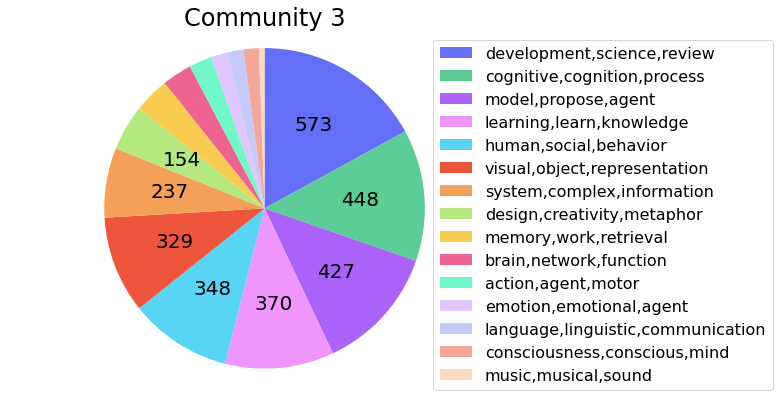

behavioral and brain sciences                                       104
cognition                                                            84
cognitive science                                                    61
quarterly journal of experimental psychology                         61
trends in cognitive sciences                                         54
journal of experimental psychology learning memory and cognition     51
psychology of learning and motivation                                50
psychological review                                                 47
psychonomic bulletin & review                                        40
philosophical psychology                                             39
dtype: int64



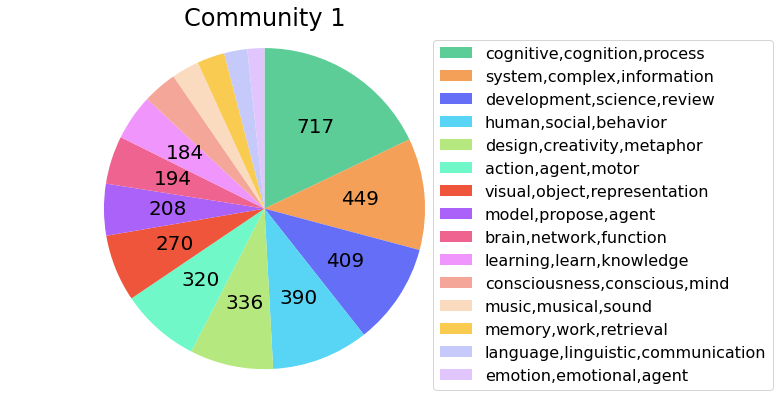

phenomenology and the cognitive sciences    129
frontiers in psychology                      91
philosophical psychology                     74
cognitive systems research                   55
synthese                                     54
new ideas in psychology                      54
behavioral and brain sciences                49
minds and machines                           48
ecological psychology                        45
adaptive behavior                            44
dtype: int64

=====
3 th pair: communities [15 14]
rho: 0.657 T: 0.8785 J: 0.443


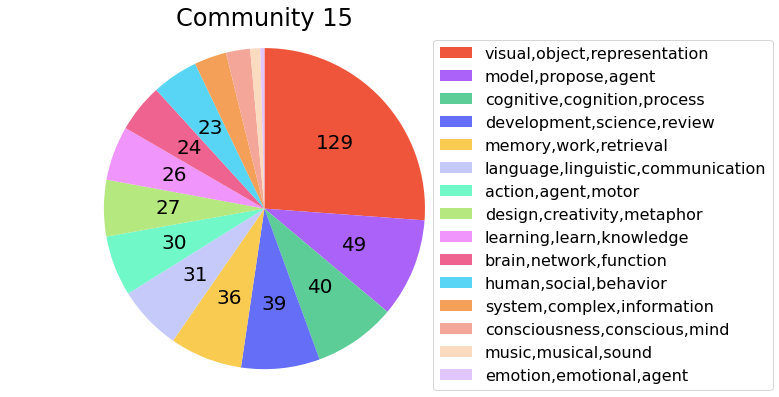

trends in cognitive sciences                                           15
journal of pragmatics                                                  14
journal of experimental psychology learning memory and cognition       10
cognitive neuropsychology                                              10
journal of experimental psychology human perception and performance     9
research on language and social interaction                             8
cognition                                                               8
neuropsychologia                                                        7
annals of the international communication association                   7
visual cognition                                                        6
dtype: int64



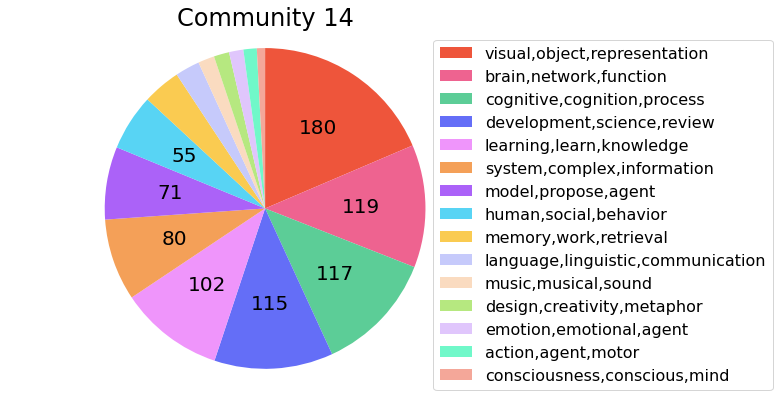

behavioral and brain sciences               40
trends in cognitive sciences                37
cognition                                   37
mind brain and education                    28
topics in cognitive science                 14
educational psychology review               13
intelligence                                13
journal of experimental child psychology    13
advances in psychology                      11
frontiers in human neuroscience             10
dtype: int64

=====
4 th pair: communities [6 4]
rho: 0.5968 T: 0.815 J: 0.4364


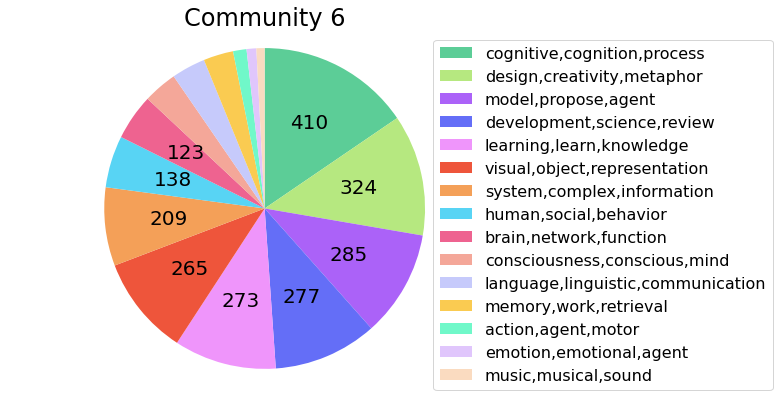

minds and machines                                                 98
cognitive science                                                  59
philosophical psychology                                           56
behavioral and brain sciences                                      51
synthese                                                           34
design studies                                                     31
journal of experimental and theoretical artificial intelligence    27
advances in psychology                                             26
topics in cognitive science                                        23
ai & society                                                       22
dtype: int64



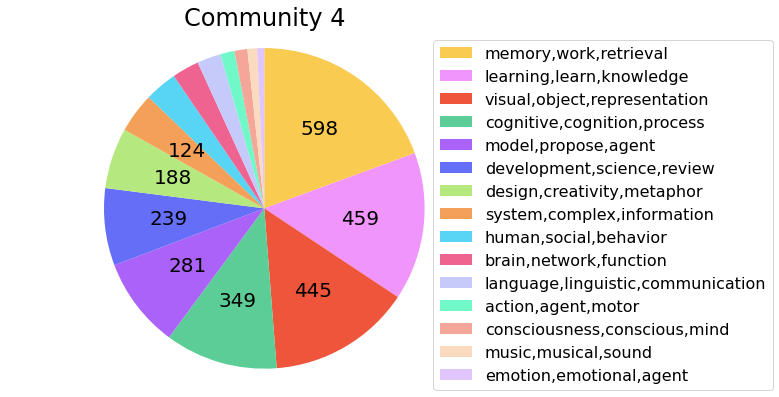

advances in psychology                                              78
memory & cognition                                                  66
journal of experimental psychology learning memory and cognition    63
applied cognitive psychology                                        61
educational psychologist                                            52
educational psychology review                                       44
psychology of learning and motivation                               43
journal of educational psychology                                   35
psychonomic bulletin & review                                       34
memory                                                              32
dtype: int64

=====
5 th pair: communities [8 4]
rho: 0.5862 T: 0.8257 J: 0.479


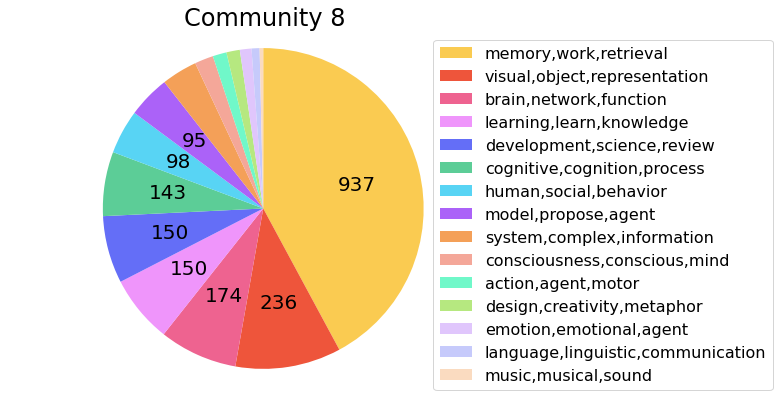

trends in cognitive sciences            84
behavioral and brain sciences           50
biorxiv                                 47
frontiers in human neuroscience         35
neuropsychologia                        34
journal of cognitive neuroscience       33
neuroscience & biobehavioral reviews    30
current biology                         30
neuron                                  30
memory                                  29
dtype: int64



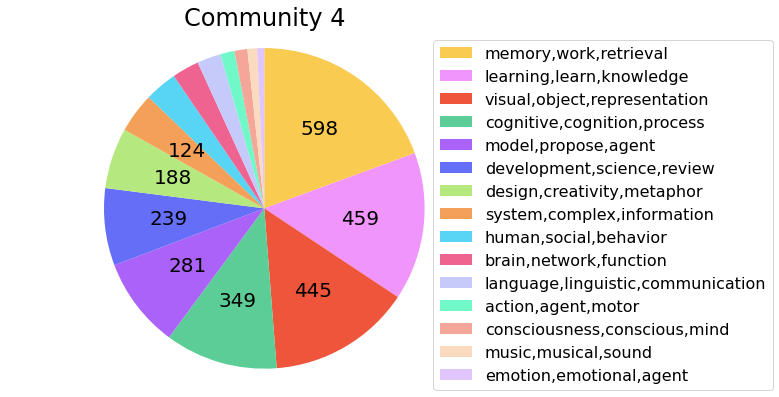

advances in psychology                                              78
memory & cognition                                                  66
journal of experimental psychology learning memory and cognition    63
applied cognitive psychology                                        61
educational psychologist                                            52
educational psychology review                                       44
psychology of learning and motivation                               43
journal of educational psychology                                   35
psychonomic bulletin & review                                       34
memory                                                              32
dtype: int64

=====
6 th pair: communities [15 11]
rho: 0.543 T: 0.7648 J: 0.4437


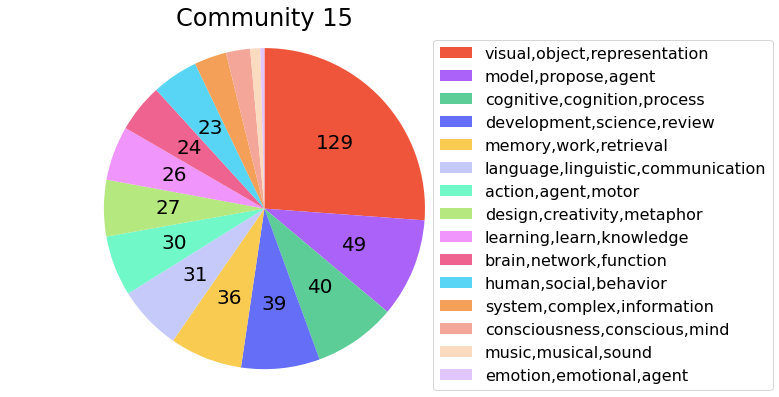

trends in cognitive sciences                                           15
journal of pragmatics                                                  14
journal of experimental psychology learning memory and cognition       10
cognitive neuropsychology                                              10
journal of experimental psychology human perception and performance     9
research on language and social interaction                             8
cognition                                                               8
neuropsychologia                                                        7
annals of the international communication association                   7
visual cognition                                                        6
dtype: int64



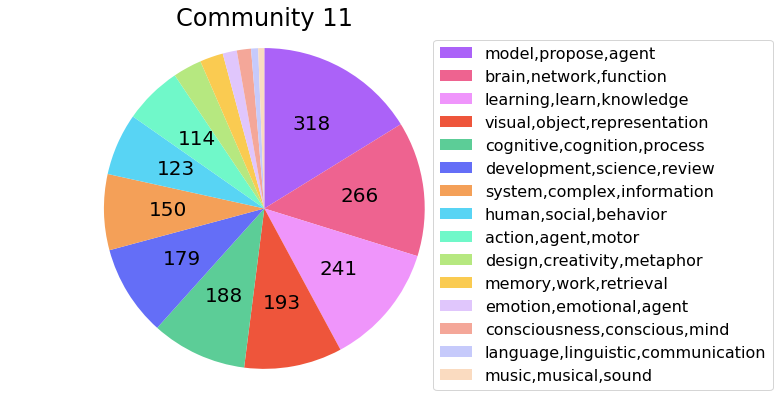

trends in cognitive sciences                         80
behavioral and brain sciences                        71
biorxiv                                              40
current opinion in behavioral sciences               35
neuron                                               34
frontiers in psychology                              32
arxiv artificial intelligence                        28
arxiv neurons and cognition                          25
cognition                                            22
philosophical transactions of the royal society b    22
dtype: int64

=====


In [15]:
pairs_oi = np.array(diff_index_mask.stack().index.tolist())
diff_index_oi = np.array([diff_index_mask.iloc[p[0],p[1]] for p in pairs_oi])
idx = np.argsort(diff_index_oi).astype(int)[::-1]
diff_index_oi, pairs_oi = diff_index_oi[idx], pairs_oi[idx]

print(len(pairs_oi), 'pairs of interest')
print('====')

for ii, p in enumerate(pairs_oi):
  print(ii, 'th pair:', 'communities', p)
  print('rho:', np.around(diff_index_oi[ii],4), 
        'T:', np.around(dot_topics.iloc[p[0], p[1]],4), 
        'J:', np.around(dot_journal.iloc[p[0], p[1]],4))
  for comm in p:
    plot_comm_pie_chart(comm)
    print(pd.Series(list_community_journals(comm)).value_counts()[:10])
    print()
  print('=====')